In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import ticker

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix, make_scorer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import plot_tree

from sklearn.dummy import DummyClassifier

from boruta import BorutaPy

from utils import plot_pie, plot_hist, plot_barh, plot_barv_date
from utils import get_freq_nan_std, get_freq_nan_tipo_combinato, get_freq_nan_data_decesso, get_freq_nan_tx
from utils import get_min_value, get_max_value
from utils import get_cost

import warnings
warnings.filterwarnings('ignore')

seed = 42
show_plot = True

<h1><span style="color:#191996">Artificial Intelligence in Industry</span></h1>

### 5-year survival rate of liver transplant patients

<br/><br/>

#### _Presented by Giacomo Pinardi_

<h2><span style="color:#191996">Table of contents</span></h2>

1. Problem analysis
2. Data loading
3. Small data description
4. Missing values
5. Creation of X and y
6. Training

<h2><span style="color:#191996">1. Problem analysis</span></h2>

Given a dataset containing information related to patients that undergo liver transplant, determine their survival rate after 5 years. 

Challanges:
 - Missing Values
 - Filtering is required
 - Unbalanced classes
 - Accuracy is not a useful metric

<h2><span style="color:#191996">2. Data loading</span></h2>

Let's create a dataframe from the Excel file:

In [2]:
df = pd.read_excel('../data.xlsx', engine='openpyxl')
df.shape

(2311, 146)

In [3]:
df.columns

Index(['ctx', 'codice_dm', 'lista_id', 'pers_sesso',
       'pers_eta_ingresso_in_lista', 'diagnosi', 'diagnosi_specifica', 'eltr',
       'lista_ingresso_data', 'tot_tx_organo',
       ...
       'donatore_HBeAg', 'donatore_HBeAb', 'donatore_antiCoreTot',
       'donatore_hbv_dna', 'donatore_hcv_rna', 'donatore_steatosiMacro',
       'donatore_biopsiaEpatica', 'donatore_biopsiaRenale',
       'donatore_livelloRischioPreLT', 'donatore_variazioneLivello'],
      dtype='object', length=146)

Remove unnecessary or not useful columns:

In [4]:
to_remove = ['ctx', 'codice_dm', 'lista_id', 'diagnosi_specifica', 'eltr', 'ric_eccezione_MELD_PELD', 'Na', 'chirurgia_addom_note', 'trombosi_portale_note', 'categoria_HCC', 'HCC_esordio', 'HCC_noduli', 'HCC_downstaging', 'HCC_diam_max', 'HCC_diam_totale', 'HCC_stadio_TNM', 'HCC_resezione', 'tx_effettivo_data', 'scheda48h_tx_effettivo_combinato', 'scheda48h_tipo_tx_effettivo_combinato', 'fega_note', 'data_UNOS', 'ISO2_tipo_super_urgenza', 'ISO2_Ecc. MELD', 'ISO2_valid_score', 'ISO2_valid_increment', 'ISO2_valid_giorni', 'ISO2_valid_mesi', 'ISO2_valid_anzianita', 'ISO2_allocazione', 'codice_sit_donazione', 'donazione_ospedale', 'donazione_sede', 'trap_don_decesso_id', 'donatore_decesso_note', 'donatore_note', 'donatore_giorni_ricovero', 'donatore_cardiopatie_desc', 'donatore_ipertensione_desc', 'donatore_diabete_desc', 'donatore_diabete_insulinodipendente_desc', 'donatore_dislipidemie_desc', 'donatore_bassaportata1_data', 'donatore_bassaportata1_ora', 'donatore_bassaportata1_durata', 'donatore_bassaportata1_PAmax', 'donatore_bassaportata1_PAmin', 'donatore_bassaportata1_trattamento', 'donatore_bassaportata2_data', 'donatore_bassaportata2_ora', 'donatore_bassaportata2_durata', 'donatore_bassaportata2_PAmax', 'donatore_bassaportata2_PAmin', 'donatore_bassaportata2_trattamento', 'donatore_bassaportata3_data', 'donatore_bassaportata3_ora', 'donatore_bassaportata3_durata', 'donatore_bassaportata3_PAmax', 'donatore_bassaportata3_PAmin', 'donatore_bassaportata3_trattamento', 'donatore_HBeAg', 'donatore_biopsiaEpatica', 'donatore_biopsiaRenale', 'donatore_variazioneLivello']

df = df.drop(to_remove, axis=1)

print(f'Removed {len(to_remove)} columns from the dataframe')

Removed 64 columns from the dataframe


In [5]:
df.shape

(2311, 82)

<h2><span style="color:#191996">3. Small data description</span></h2>

The dataframe file contains different patient "types" (someone received a transplant, others left since their condition improved, ...).

In [6]:
df[['pers_sesso', 'MELD_base', 'diagnosi', 'causa_uscita', 'data_trapianto', 'donatore_eta']]

,pers_sesso,MELD_base,diagnosi,causa_uscita,data_trapianto,donatore_eta
0,M,8.0,Altra epatopatia,TX nel centro di iscrizione,2004-10-22,19.0
1,M,10.0,Cirrosi postnecrotica da HCV,Non idoneo clinicamente,NaT,NaN
2,M,13.0,Cirrosi criptogenetica o idiopatica,Uscito per miglioramento,NaT,NaN
3,M,14.0,Cirrosi di Laennec (post-alcolica),Deceduto iscritto in lista,NaT,NaN
4,M,16.0,Cirrosi postnecrotica da HCV,Deceduto iscritto in lista,NaT,NaN
...,...,...,...,...,...,...
2306,M,12.0,Epatocarcinoma associato a cirrosi,TX nel centro di iscrizione,2020-12-08,53.0
2307,M,18.0,Localizzazione epatiche di neoplasie maligne o...,TX nel centro di iscrizione,2020-10-23,46.0
2308,M,9.0,Epatocarcinoma associato a cirrosi,TX nel centro di iscrizione,2020-11-07,82.0
2309,F,25.0,Cirrosi biliare primitiva,TX nel centro di iscrizione,2020-12-29,70.0


In [7]:
df.head()

,pers_sesso,pers_eta_ingresso_in_lista,diagnosi,lista_ingresso_data,tot_tx_organo,tx_fegato_corrente,iscriz_tx_comb,tipo_combinato,ric_HBsAg,ric_DELTA,...,donatore_arresto_cardiaco,donatore_hcv,donatore_HBsAg,donatore_HBsAb,donatore_HBeAb,donatore_antiCoreTot,donatore_hbv_dna,donatore_hcv_rna,donatore_steatosiMacro,donatore_livelloRischioPreLT
0,M,54,Altra epatopatia,2004-03-10,0.0,1.0,SI,cuore - fegato,NO,NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M,64,Cirrosi postnecrotica da HCV,2003-12-02,NaN,NaN,NO,NaN,NO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M,56,Cirrosi criptogenetica o idiopatica,2002-07-18,0.0,1.0,NO,NaN,NO,NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M,51,Cirrosi di Laennec (post-alcolica),2003-06-26,NaN,NaN,NO,NaN,NO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M,43,Cirrosi postnecrotica da HCV,2004-01-08,NaN,NaN,NO,NaN,NO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.describe()

,pers_eta_ingresso_in_lista,tot_tx_organo,tx_fegato_corrente,Peso,Altezza,BMI,MELD_in_ingresso,MELD_in_uscita,MELD_base,MELD_na,...,donatore_bilirubinaTot1,donatore_bilirubinaTot2,donatore_bilirubinaTot3,donatore_fosfatasi1,donatore_fosfatasi2,donatore_fosfatasi3,donatore_gammaGT1,donatore_gammaGT2,donatore_gammaGT3,donatore_steatosiMacro
count,2311.000000,1847.000000,1852.000000,2261.000000,2260.000000,2260.000000,591.000000,591.000000,2259.000000,163.000000,...,780.000000,735.000000,528.00000,308.000000,536.000000,357.000000,399.000000,593.000000,391.000000,767.000000
mean,52.361748,0.102328,1.072354,73.536444,169.861062,25.385093,17.065990,18.367174,19.130146,21.306748,...,0.761744,0.853116,1.02608,99.042208,100.472015,113.743249,45.858822,46.215852,66.798210,6.091134
std,10.332137,0.338613,0.281142,15.177244,9.086432,4.392849,8.810474,9.634448,9.211320,9.453154,...,0.658497,0.772087,4.06535,63.488706,123.688006,95.895910,62.604162,64.369294,95.280876,7.951754
min,11.000000,0.000000,1.000000,23.000000,127.000000,11.400000,6.000000,6.000000,6.000000,6.000000,...,0.100000,0.060000,0.10000,13.000000,0.400000,3.340000,0.670000,0.000000,0.100000,0.000000
25%,47.000000,0.000000,1.000000,63.000000,164.000000,22.477500,10.000000,10.500000,12.000000,14.000000,...,0.410000,0.440000,0.42000,55.000000,52.000000,60.000000,14.000000,15.000000,17.000000,0.000000
50%,54.000000,0.000000,1.000000,73.000000,170.000000,25.060000,15.000000,16.000000,17.000000,21.000000,...,0.600000,0.680000,0.63000,77.000000,71.000000,88.000000,24.000000,24.000000,33.000000,5.000000
75%,60.000000,0.000000,1.000000,83.000000,176.000000,27.920000,22.000000,25.000000,26.000000,28.500000,...,0.910000,1.000000,0.99250,125.250000,110.250000,138.000000,48.000000,46.000000,78.000000,10.000000
max,73.000000,3.000000,4.000000,133.000000,205.000000,46.290000,56.000000,51.000000,51.000000,48.000000,...,10.900000,8.900000,92.00000,374.000000,1959.000000,914.000000,496.000000,576.000000,1013.000000,50.000000


<h2><span style="color:#191996">4. Missing values</span></h2>

### Rough estimation of missing values
Every `NaN` value is considered a missing value.

In [9]:
missing_percent = {}
for column in df.columns:
    missing_percent[column] = df[column].isna().sum() / len(df)
for column in sorted(missing_percent, key=missing_percent.get, reverse=True):
    print('{}: {:.3f}'.format(column, missing_percent[column]))

tipo_combinato: 0.944
donatore_HBeAb: 0.935
MELD_na: 0.929
donatore_fosfatasi1: 0.867
MELD_HCC: 0.864
donatore_fosfatasi3: 0.846
donatore_gammaGT3: 0.831
donatore_gammaGT1: 0.827
donatore_AST3: 0.776
donatore_bilirubinaTot3: 0.772
donatore_fosfatasi2: 0.768
donatore_ALT3: 0.756
MELD_in_ingresso: 0.744
MELD_in_uscita: 0.744
donatore_sodio3: 0.744
donatore_gammaGT2: 0.743
AFP: 0.734
ultimo_stato_tx: 0.694
data_ultimo_agg_followup: 0.692
donatore_AST2: 0.691
donatore_AST1: 0.688
donatore_bilirubinaTot2: 0.682
rigetto: 0.669
donatore_steatosiMacro: 0.668
data_decesso: 0.667
donatore_ALT2: 0.666
donatore_bilirubinaTot1: 0.662
ric_ripresa_funzionale: 0.642
donatore_sodio2: 0.630
donatore_hbv_dna: 0.628
donatore_diabete_insulinodipendente: 0.626
donatore_hcv_rna: 0.625
donatore_ALT1: 0.623
donatore_HBsAb: 0.613
donatore_sodio1: 0.575
TIPS: 0.527
dialisi_ultimi_15gg: 0.505
ric_DELTA: 0.505
donatore_livelloRischioPreLT: 0.495
donatore_dislipidemie: 0.494
donatore_arresto_cardiaco: 0.484
donator

In [10]:
# Overall dataset
print('{:.3f}'.format(df.isna().sum().sum() / (len(df) * len(df.columns))))

0.460


#### Strategies to deal with missing values:
- Talk to the expert: is there a **default value** that can be used?


- Statistical approach, using **missing values imputation**:
    - Univariate feature imputation with `SimpleImputer` (mean, most frequent, ...);
    - Multivariate feature imputation with `IterativeImputer` (model each feature with missing values as a function of other features).


- Remove row/column with too many missing values. Should be avoided when the above strategies are possible.

### Precise estimation of missing values
A `NaN` value is considered a missing value depending on the context. If the patient did not receive a transplant then the values related to the nonexistent donor are **not** missing values. 

In [11]:
def get_freq_nan_tx (df: pd.DataFrame, column_name: str):
    tx = ['TX nel centro di iscrizione',
          'Trapiantato da VIVENTE in questo Centro',
          'Trapianto in altra sede non specificata',
          'Trapianto AIRT fuori Regione']
    
    return ((df['causa_uscita'].isin(tx)) & (pd.isna(df[column_name]))).sum() / len(df)

- Feature: `pers_sesso`

Missing pers_sesso: 0.00


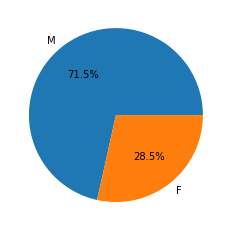

In [12]:
column = 'pers_sesso'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `pers_eta_ingresso_in_lista`

Missing pers_eta_ingresso_in_lista: 0.00


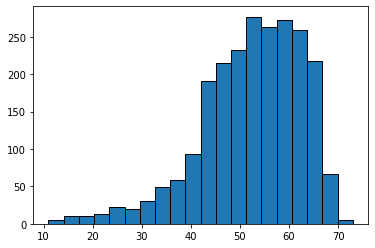

In [13]:
column = 'pers_eta_ingresso_in_lista'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `diagnosi`

Missing diagnosi: 0.05


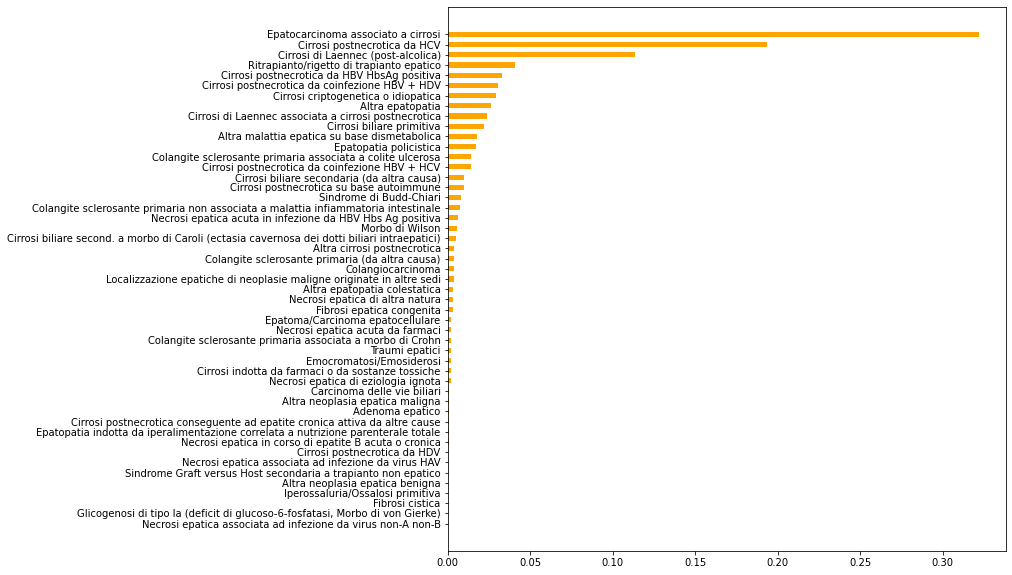

In [14]:
column = 'diagnosi'
if show_plot:
    plt.figure(figsize=(10, 10));
    plot_barh(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `lista_ingresso_data`

Missing lista_ingresso_data: 0.00


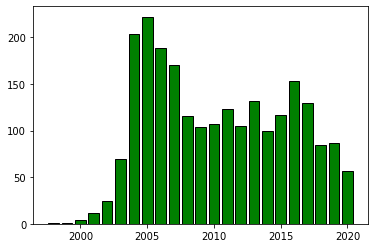

In [15]:
column = 'lista_ingresso_data'
plot_barv_date(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `tot_tx_organo`

Missing tot_tx_organo: 0.20


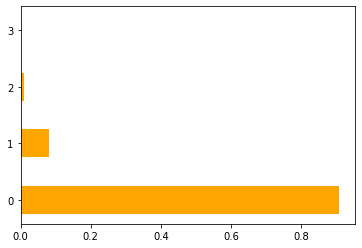

In [16]:
column = 'tot_tx_organo'

if show_plot:    
    vc = df[column].value_counts(normalize=True)
    plt.barh(vc.index, vc.values, height=0.5, color='orange')
    locator = ticker.MultipleLocator(1)
    plt.gca().yaxis.set_major_locator(locator)
    
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `tx_fegato_corrente`

Missing tx_fegato_corrente: 0.20


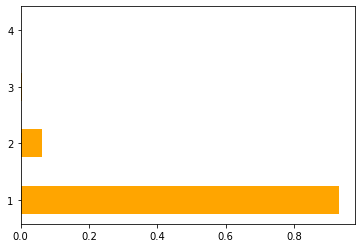

In [17]:
column = 'tx_fegato_corrente'

if show_plot:    
    vc = df[column].value_counts(normalize=True)
    plt.barh(vc.index, vc.values, height=0.5, color='orange')
    locator = ticker.MultipleLocator(1)
    plt.gca().yaxis.set_major_locator(locator)

print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

Using SimpleImputer to remove NaN(s) values form _tot_tx_organo_ and _tx_fegato_corrente_:

In [18]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[['tot_tx_organo', 'tx_fegato_corrente']] = imp.fit_transform(df[['tot_tx_organo', 'tx_fegato_corrente']])

In [19]:
print('Missing {}: {:.2f}'.format('tot_tx_organo', get_freq_nan_std(df, 'tot_tx_organo')))
print('Missing {}: {:.2f}'.format('tx_fegato_corrente', get_freq_nan_std(df, 'tx_fegato_corrente')))

Missing tot_tx_organo: 0.00
Missing tx_fegato_corrente: 0.00


- Feature: `iscriz_tx_comb`

Missing iscriz_tx_comb: 0.00


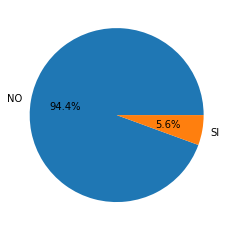

In [20]:
column = 'iscriz_tx_comb'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `tipo_combinato`

Missing tipo_combinato: 0.00


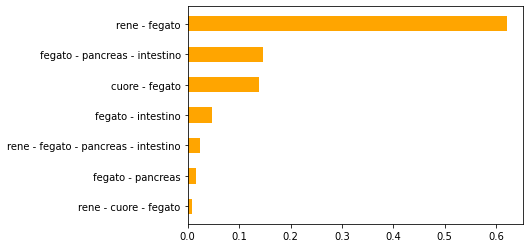

In [21]:
column = 'tipo_combinato'
plot_barh(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tipo_combinato(df)))

From a single column on the combined transplant we obtain 4 extra columns (_tx_rene_, _tx_pancreas_, _tx_intestino_, _tx_cuore_). The column _tx_fegato_ has no sense because all patients should have this field _true_.

After this addition columns _iscriz_tx_comb_ and _tipo_combinato_ can be dropped.

In [22]:
df.insert(8, 'tx_rene', 0)
df.insert(8, 'tx_pancreas', 0)
df.insert(8, 'tx_intestino', 0)
df.insert(8, 'tx_cuore', 0)

In [23]:
organs = ['rene', 'pancreas', 'intestino', 'cuore']
for i in range(len(df)):
    if not pd.isna(df.iloc[i]['tipo_combinato']):
        for o in organs:
            if o in df.iloc[i]['tipo_combinato']:
                df.loc[i, 'tx_' + o] = 1

In [24]:
df.drop('iscriz_tx_comb', axis=1, inplace=True)
df.drop('tipo_combinato', axis=1, inplace=True)

- Feature: `ric_HBsAg` (Hepatitis B)

Missing ric_HBsAg: 0.04


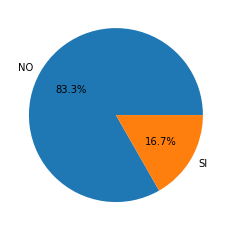

In [25]:
column = 'ric_HBsAg'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `ric_DELTA` (Hepatitis D)

In [26]:
column = 'ric_DELTA'
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

Missing ric_DELTA: 0.50


A lot of missing values, but it seems that Hepatitis D can only be present along with Hepatitis B. [1] So if `ric_HBsAg` is not detected (value `NO`) then `ric_DELTA` should not be present.

In [27]:
def exploit_dependence(row, dependent, independent):
    if pd.isna(row[dependent]) and row[independent] == 'NO':
        return 'NO'
    else:
        return row[dependent]

df['ric_DELTA'] = df.apply(lambda x: exploit_dependence(x, 'ric_DELTA', 'ric_HBsAg'), axis=1)

Missing ric_DELTA: 0.05


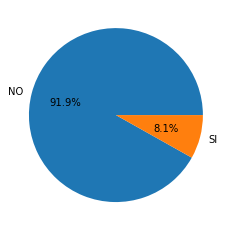

In [28]:
column = 'ric_DELTA'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `ric_HCV` (Hepatitis C)

Missing ric_HCV: 0.04


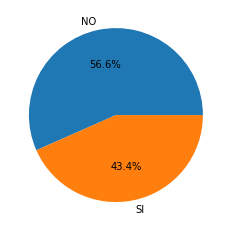

In [29]:
column = 'ric_HCV'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `ric_HCV_RNA`

In [30]:
column = 'ric_HCV_RNA'
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

Missing ric_HCV_RNA: 0.42


A lot of missing values, but it seems that Hepatitis C RNA can only be present along with Hepatitis C. [2] So if _ric_HCV_ is not detected (value _NO_) then _ric_HCV_RNA_ should not be present.

In [31]:
df['ric_HCV_RNA'] = df.apply(lambda x: exploit_dependence(x, 'ric_HCV_RNA', 'ric_HCV'), axis=1)

Missing ric_HCV_RNA: 0.06


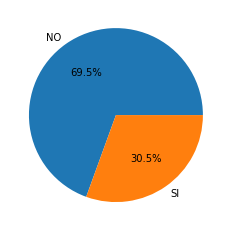

In [32]:
column = 'ric_HCV_RNA'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `ric_HIV`

Missing ric_HIV: 0.04


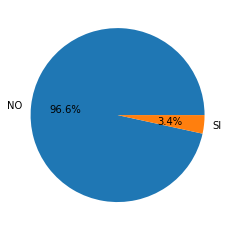

In [33]:
column = 'ric_HIV'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `Peso`

Missing Peso: 0.02


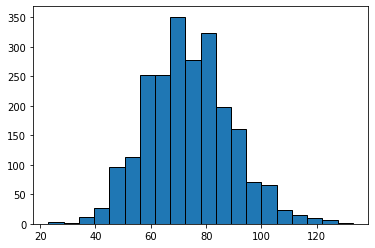

In [34]:
column = 'Peso'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `Altezza`

Missing Altezza: 0.02


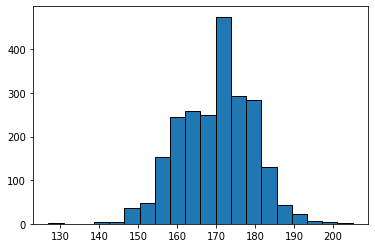

In [35]:
column = 'Altezza'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `BMI`

Missing BMI: 0.02


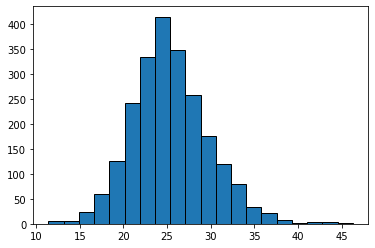

In [36]:
column = 'BMI'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `MELD_in_ingresso`

Missing MELD_in_ingresso: 0.74


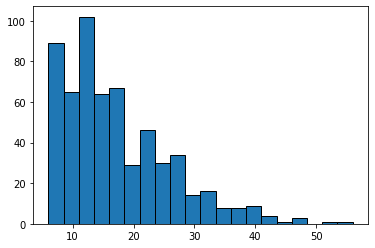

In [37]:
column = 'MELD_in_ingresso'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `MELD_in_uscita`

Missing MELD_in_uscita: 0.74


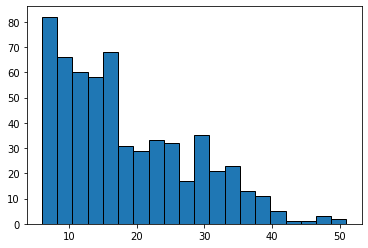

In [38]:
column = 'MELD_in_uscita'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `chirurgia_addom`

Missing chirurgia_addom: 0.04


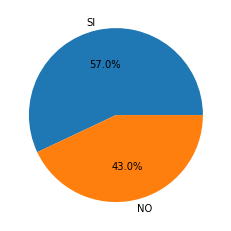

In [39]:
column = 'chirurgia_addom'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `trombosi_portale`

Missing trombosi_portale: 0.04


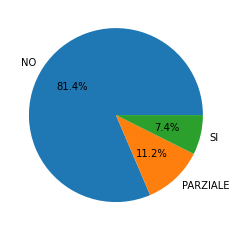

In [40]:
column = 'trombosi_portale'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `TIPS`

Missing TIPS: 0.53


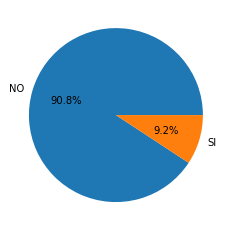

In [41]:
column = 'TIPS'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `ric_diabete`

Missing ric_diabete: 0.22


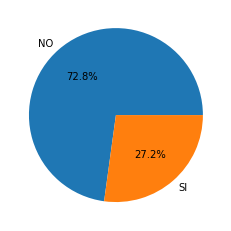

In [42]:
column = 'ric_diabete'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `HCC`

Missing HCC: 0.03


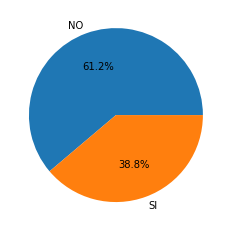

In [43]:
column = 'HCC'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

**MELD** (Model End-stage Liver Disease) score is used to assess the severity of liver disease. [3] It can be used to estimate the survival rate of patients in list for a transplant: a lower score represents a lower mortality during a 3-month follow-up period. [4]

`MELD = round(3.78*ln(a) + 11.2*ln(b) + 9.57*ln(c) + 6.43)`

where `a`, `b`, `c` are patient's parameters obtained from a blood test that descrive how well the liver is working.

Other (more accurate) scores are based on MELD:
- MELD-Na
- MELD-Plus
- HCC-MELD

- Feature: `MELD_base`

Missing MELD_base: 0.02


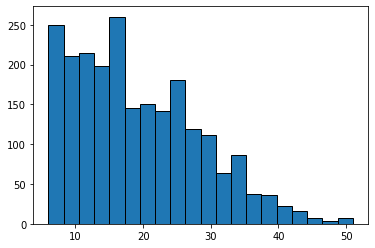

In [44]:
column = 'MELD_base'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `CHILD`

Similar to the MELD score, the Child score assesses the condition of the patient based on 5 clinical measures. Each measure contributes to the final score with 1-3 points. The smaller is the score and the higher are the survival chances.

Missing CHILD: 0.24


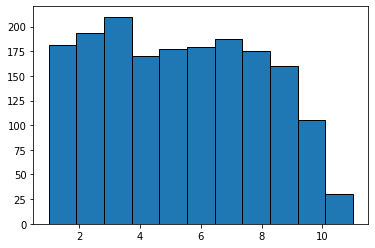

In [45]:
column = 'CHILD'
plt.hist(df[column].apply(lambda v: np.nan if pd.isna(v) else int(v[1:])-4), bins=11, edgecolor='black');
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `MELD_na`

Missing MELD_na: 0.93


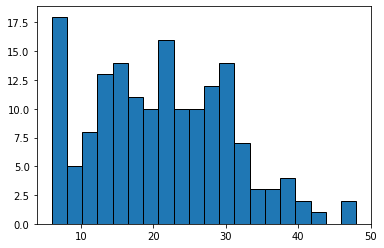

In [46]:
column = 'MELD_na'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `MELD_HCC`

Missing MELD_HCC: 0.86


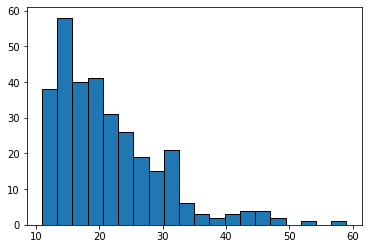

In [47]:
column = 'MELD_HCC'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `AFP`

Missing AFP: 0.73


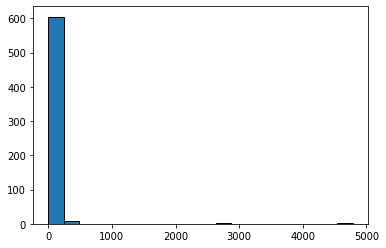

In [48]:
column = 'AFP'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `dialisi_ultimi_15gg`

Missing dialisi_ultimi_15gg: 0.51


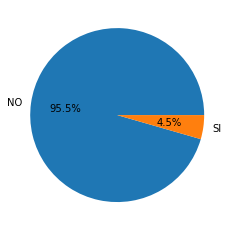

In [49]:
column = 'dialisi_ultimi_15gg'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `lista_uscita_data`

Missing lista_uscita_data: 0.00


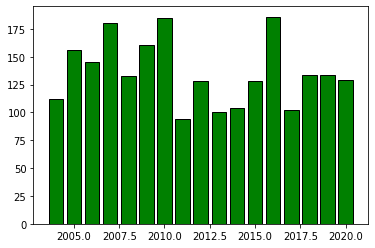

In [50]:
column = 'lista_uscita_data'
plot_barv_date(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `causa_uscita`

Missing causa_uscita: 0.00


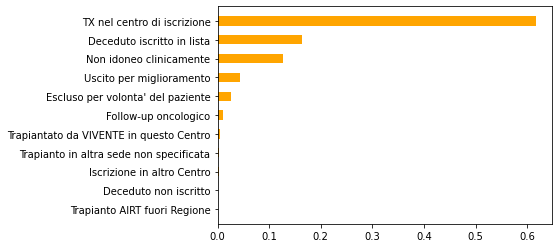

In [51]:
column = 'causa_uscita'
plot_barh(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `data_decesso`

Missing data_decesso: 0.00


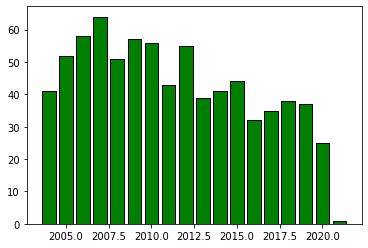

In [52]:
column = 'data_decesso'
plot_barv_date(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_data_decesso(df)))

- Feature: `UNOS`

Missing UNOS: 0.06


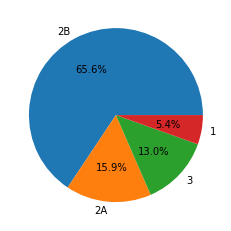

In [53]:
column = 'UNOS'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `ISO2_super_urgenza`

Missing ISO2_super_urgenza: 0.00


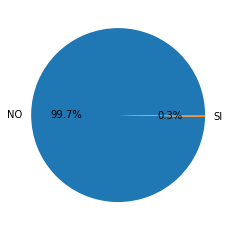

In [54]:
column = 'ISO2_super_urgenza'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_std(df, column)))

- Feature: `ric_ospedalizzazione_al_tx`

Missing ric_ospedalizzazione_al_tx: 0.09


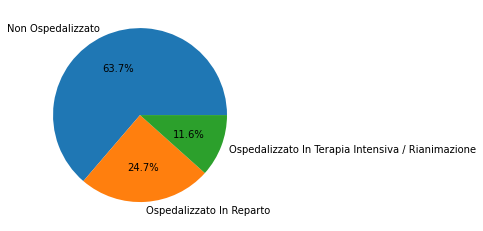

In [55]:
column = 'ric_ospedalizzazione_al_tx'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `data_trapianto`

Missing data_trapianto: 0.00


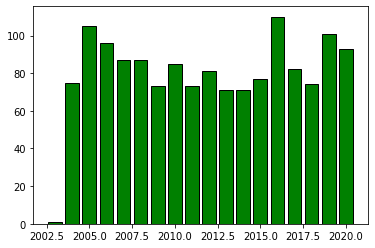

In [56]:
column = 'data_trapianto'
plot_barv_date(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `organo_trapiantato`

Missing organo_trapiantato: 0.09


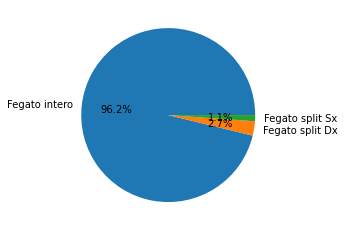

In [57]:
column = 'organo_trapiantato'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `ischemia_fredda`

Convert the hh:mm:ss format into number of minutes for easier processing:

In [58]:
def process (x):
    if not pd.isna(x):
        spl = x.split(':')
        return int(spl[0])*60 + int(spl[1])
    return np.nan

df['ischemia_fredda'] = df['ischemia_fredda'].apply(process)

Missing ischemia_fredda: 0.00


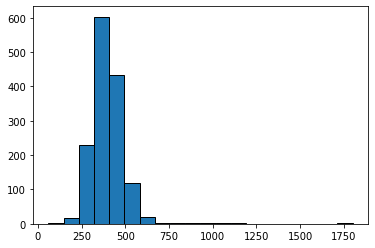

In [59]:
column = 'ischemia_fredda'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `ric_ripresa_funzionale`

Missing ric_ripresa_funzionale: 0.27


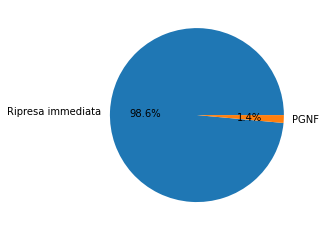

In [60]:
column = 'ric_ripresa_funzionale'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `rigetto`

Missing rigetto: 0.29


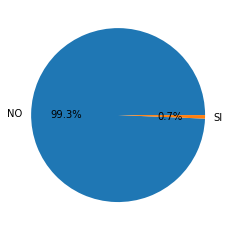

In [61]:
column = 'rigetto'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `ultimo_stato_tx`

Missing ultimo_stato_tx: 0.32


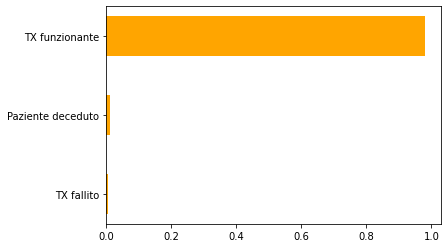

In [62]:
column = 'ultimo_stato_tx'
plot_barh(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `data_ultimo_agg_followup`

Missing data_ultimo_agg_followup: 0.32


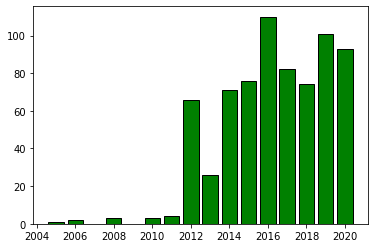

In [63]:
column = 'data_ultimo_agg_followup'
plot_barv_date(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_eta`

Missing donatore_eta: 0.01


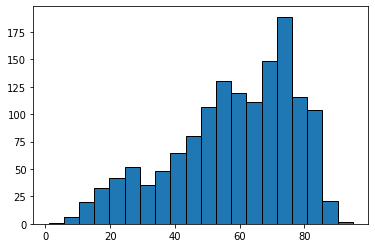

In [64]:
column = 'donatore_eta'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_sesso`

Missing donatore_sesso: 0.01


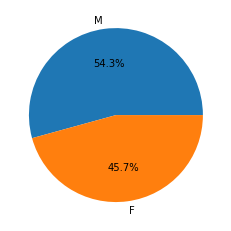

In [65]:
column = 'donatore_sesso'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_caus_decesso`

Missing donatore_caus_decesso: 0.01


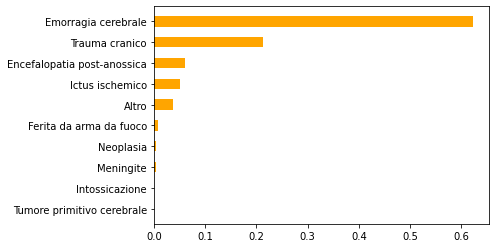

In [66]:
column = 'donatore_caus_decesso'
plot_barh(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `tipo_donazione`

Missing tipo_donazione: 0.00


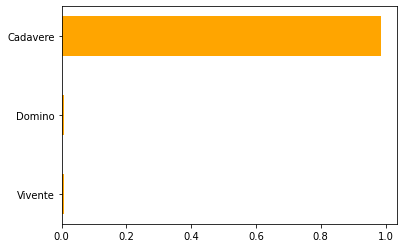

In [67]:
column = 'tipo_donazione'
plot_barh(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_peso`

Missing donatore_peso: 0.09


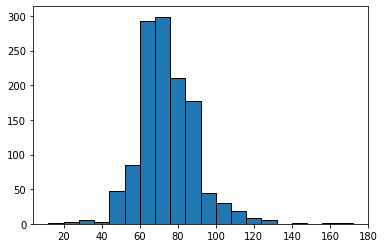

In [68]:
column = 'donatore_peso'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_altezza`

Missing donatore_altezza: 0.09


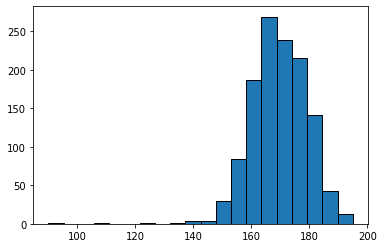

In [69]:
column = 'donatore_altezza'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_BMI`

Missing donatore_BMI: 0.09


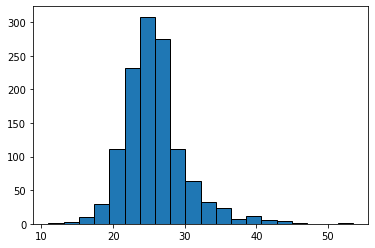

In [70]:
column = 'donatore_BMI'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_cardiopatia`

Missing donatore_cardiopatia: 0.11


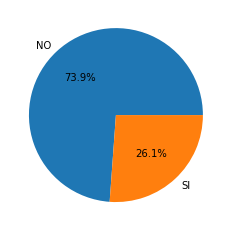

In [71]:
column = 'donatore_cardiopatia'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_ipertensione`

Missing donatore_ipertensione: 0.10


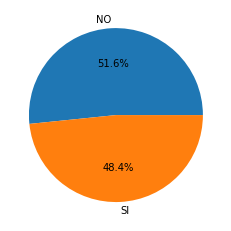

In [72]:
column = 'donatore_ipertensione'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_diabete`

Missing donatore_diabete: 0.10


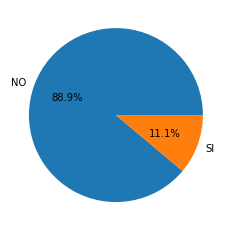

In [73]:
column = 'donatore_diabete'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_diabete_insulinodipendente`

In [74]:
column = 'donatore_diabete_insulinodipendente'
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

Missing donatore_diabete_insulinodipendente: 0.25


Patients without diabetes (`donatore_diabete`) should have `NO` in this field:

In [75]:
df['donatore_diabete_insulinodipendente'] = df.apply(lambda x: exploit_dependence(x, 'donatore_diabete_insulinodipendente', 'donatore_diabete'), axis=1)

Missing donatore_diabete_insulinodipendente: 0.11


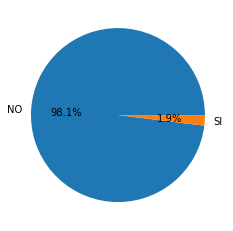

In [76]:
column = 'donatore_diabete_insulinodipendente'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_dislipidemie`

Missing donatore_dislipidemie: 0.12


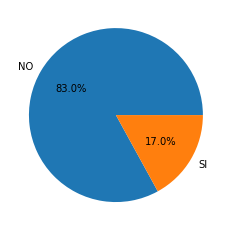

In [77]:
column = 'donatore_dislipidemie'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_sodio`

Missing donatore_sodio1: 0.20
Missing donatore_sodio2: 0.25
Missing donatore_sodio3: 0.37


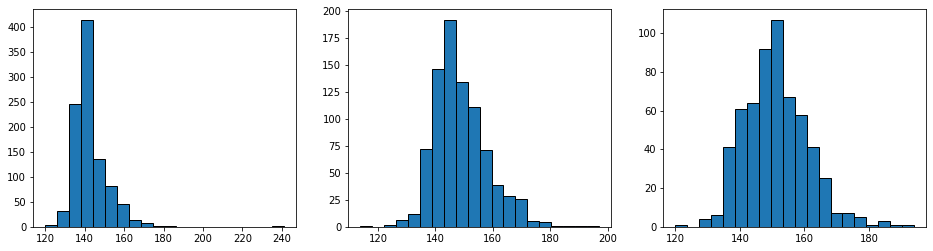

In [78]:
column = 'donatore_sodio'
plt.figure(figsize=(16, 4))
if show_plot:
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.hist(data=df, x=column + str(i), bins=20, edgecolor='black');

for i in range(1, 4):
    print('Missing {}: {:.2f}'.format(column + str(i), get_freq_nan_tx(df, column + str(i))))

To overcome the large number of missing values we can:
- compute the mean over the valid measurements,
- the average is `NaN` only if all values are `NaN`

In [79]:
def compute_mean(row, column):
    data = [row[column + str(1)], row[column + str(2)], row[column + str(3)]]
    total = np.nansum(data)
    count = (~np.isnan(data)).sum()
    
    if count == 0:
        return np.nan
    
    return total / count

In [80]:
index = df.columns.get_loc('donatore_sodio3')+1
df.insert(index, 'donatore_sodio_avg', False)

df['donatore_sodio_avg'] = df.apply(lambda x: compute_mean(x, 'donatore_sodio'), axis=1)

In [81]:
df.drop('donatore_sodio1', axis=1, inplace=True)
df.drop('donatore_sodio2', axis=1, inplace=True)
df.drop('donatore_sodio3', axis=1, inplace=True)

Missing donatore_sodio_avg: 0.10


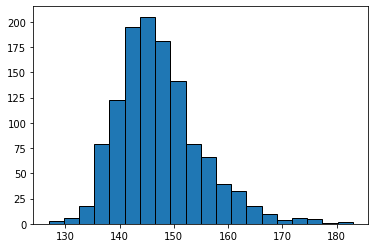

In [82]:
column = 'donatore_sodio_avg'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_AST`

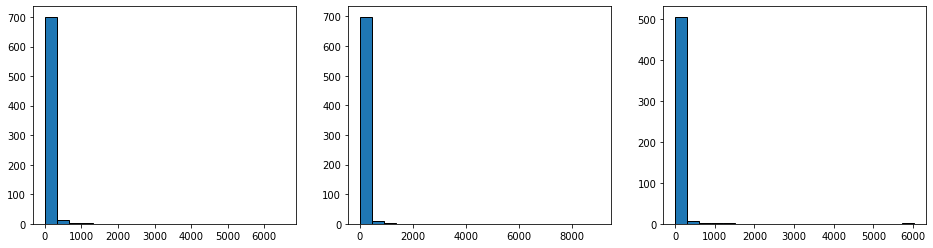

In [83]:
column = 'donatore_AST'

plt.figure(figsize=(16, 4))

if show_plot:
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.hist(data=df, x=column + str(i), bins=20, edgecolor='black');

In [84]:
df.loc[df['donatore_AST1'] > 1000, ['donatore_AST1', 'donatore_AST2', 'donatore_AST3']]

,donatore_AST1,donatore_AST2,donatore_AST3
195,1218.0,521.0,NaN
584,1378.0,427.0,303.0
647,1159.0,923.0,NaN
1756,6538.0,9001.0,6021.0
2231,1154.0,1060.0,NaN


Remove extreme values:

In [85]:
index1 = df.loc[df['donatore_AST1'] > 1000].index
index2 = df.loc[df['donatore_AST2'] > 1000].index
index3 = df.loc[df['donatore_AST3'] > 1000].index

df.loc[index1, 'donatore_AST1'] = np.nan
df.loc[index2, 'donatore_AST2'] = np.nan
df.loc[index3, 'donatore_AST3'] = np.nan

Missing donatore_AST1: 0.31
Missing donatore_AST2: 0.32
Missing donatore_AST3: 0.40


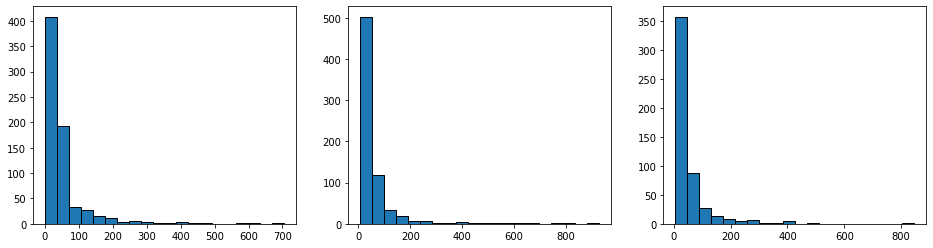

In [86]:
column = 'donatore_AST'

plt.figure(figsize=(16, 4))

if show_plot:
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.hist(data=df, x=column + str(i), bins=20, edgecolor='black');
    
for i in range(1, 4):
    print('Missing {}: {:.2f}'.format(column + str(i), get_freq_nan_tx(df, column + str(i))))

To overcome the large number of missing values we can calculate the mean over the three measurements:

In [87]:
index = df.columns.get_loc('donatore_AST3')+1
df.insert(index, 'donatore_AST_avg', False)

df['donatore_AST_avg'] = df.apply(lambda x: compute_mean(x, 'donatore_AST'), axis=1)

df.drop('donatore_AST1', axis=1, inplace=True)
df.drop('donatore_AST2', axis=1, inplace=True)
df.drop('donatore_AST3', axis=1, inplace=True)

Missing donatore_AST_avg: 0.12


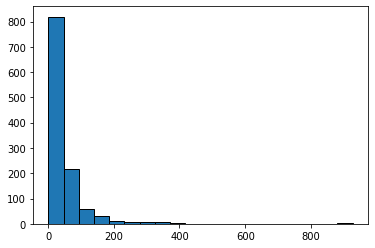

In [88]:
column = 'donatore_AST_avg'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_ALT`

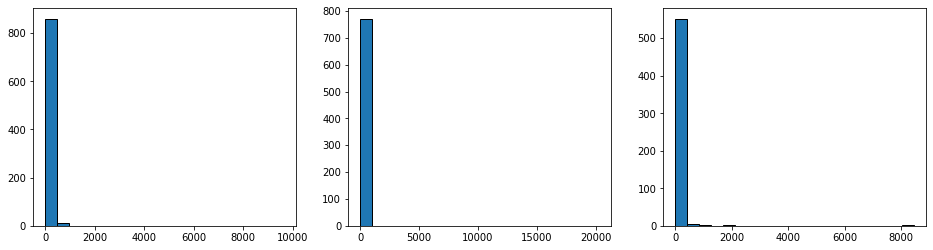

In [89]:
column = 'donatore_ALT'

plt.figure(figsize=(16, 4))

if show_plot:
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.hist(data=df, x=column + str(i), bins=20, edgecolor='black');

In [90]:
df.loc[df['donatore_ALT3'] > 1000, ['donatore_ALT1', 'donatore_ALT2', 'donatore_ALT3']]

,donatore_ALT1,donatore_ALT2,donatore_ALT3
1502,523.0,NaN,1122.0
1756,9629.0,9048.0,8449.0
2183,NaN,324.0,1857.0


Remove extreme values:

In [91]:
index1 = df.loc[df['donatore_ALT1'] > 1000].index
index2 = df.loc[df['donatore_ALT2'] > 1000].index
index3 = df.loc[df['donatore_ALT3'] > 1000].index

df.loc[index1, 'donatore_ALT1'] = np.nan
df.loc[index2, 'donatore_ALT2'] = np.nan
df.loc[index3, 'donatore_ALT3'] = np.nan

Missing donatore_ALT1: 0.25
Missing donatore_ALT2: 0.29
Missing donatore_ALT3: 0.38


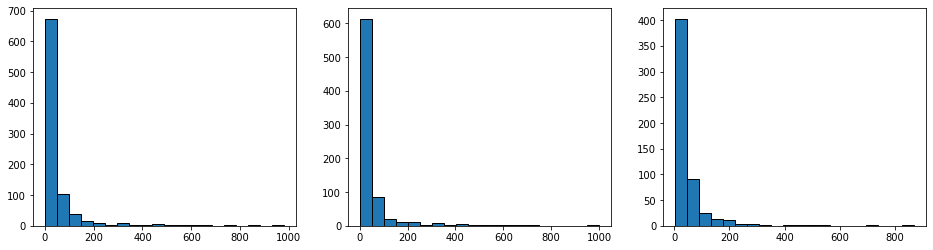

In [92]:
column = 'donatore_ALT'

plt.figure(figsize=(16, 4))

if show_plot:
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.hist(data=df, x=column + str(i), bins=20, edgecolor='black');
    
for i in range(1, 4):
    print('Missing {}: {:.2f}'.format(column + str(i), get_freq_nan_tx(df, column + str(i))))

To overcome the large number of missing values we can calculate the mean over the three measurements:

In [93]:
index = df.columns.get_loc('donatore_ALT3')+1
df.insert(index, 'donatore_ALT_avg', False)

df['donatore_ALT_avg'] = df.apply(lambda x: compute_mean(x, 'donatore_ALT'), axis=1)

df.drop('donatore_ALT1', axis=1, inplace=True)
df.drop('donatore_ALT2', axis=1, inplace=True)
df.drop('donatore_ALT3', axis=1, inplace=True)

Missing donatore_ALT_avg: 0.10


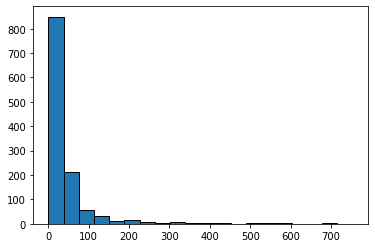

In [94]:
column = 'donatore_ALT_avg'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_bilirubinaTot`

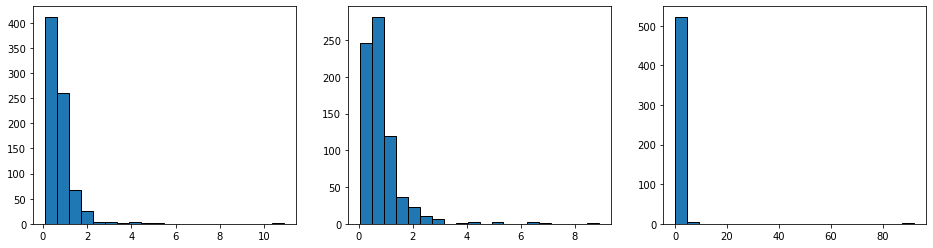

In [95]:
column = 'donatore_bilirubinaTot'

plt.figure(figsize=(16, 4))

if show_plot:
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.hist(data=df, x=column + str(i), bins=20, edgecolor='black');

In [96]:
df.loc[df['donatore_bilirubinaTot3'] > 20, ['donatore_bilirubinaTot1', 'donatore_bilirubinaTot2', 'donatore_bilirubinaTot3']]

,donatore_bilirubinaTot1,donatore_bilirubinaTot2,donatore_bilirubinaTot3
1457,0.51,NaN,92.0


Remove extreme values:

In [97]:
index1 = df.loc[df['donatore_bilirubinaTot1'] > 20].index
index2 = df.loc[df['donatore_bilirubinaTot2'] > 20].index
index3 = df.loc[df['donatore_bilirubinaTot3'] > 20].index

df.loc[index1, 'donatore_bilirubinaTot1'] = np.nan
df.loc[index2, 'donatore_bilirubinaTot2'] = np.nan
df.loc[index3, 'donatore_bilirubinaTot3'] = np.nan

Missing donatore_bilirubinaTot1: 0.29
Missing donatore_bilirubinaTot2: 0.31
Missing donatore_bilirubinaTot3: 0.40


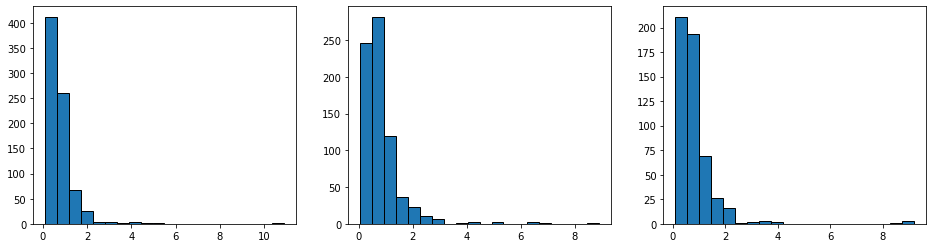

In [98]:
column = 'donatore_bilirubinaTot'

plt.figure(figsize=(16, 4))

if show_plot:
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.hist(data=df, x=column + str(i), bins=20, edgecolor='black')
        
for i in range(1, 4):
    print('Missing {}: {:.2f}'.format(column + str(i), get_freq_nan_tx(df, column + str(i))))

To overcome the large number of missing values we can calculate the mean over the three measurements:

In [99]:
index = df.columns.get_loc('donatore_bilirubinaTot3')+1
df.insert(index, 'donatore_bilirubinaTot_avg', False)

df['donatore_bilirubinaTot_avg'] = df.apply(lambda x: compute_mean(x, 'donatore_bilirubinaTot'), axis=1)

df.drop('donatore_bilirubinaTot1', axis=1, inplace=True)
df.drop('donatore_bilirubinaTot2', axis=1, inplace=True)
df.drop('donatore_bilirubinaTot3', axis=1, inplace=True)

Missing donatore_bilirubinaTot_avg: 0.10


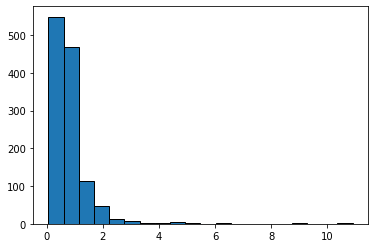

In [100]:
column = 'donatore_bilirubinaTot_avg'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_fosfatasi`

Missing donatore_fosfatasi1: 0.49
Missing donatore_fosfatasi2: 0.39
Missing donatore_fosfatasi3: 0.47


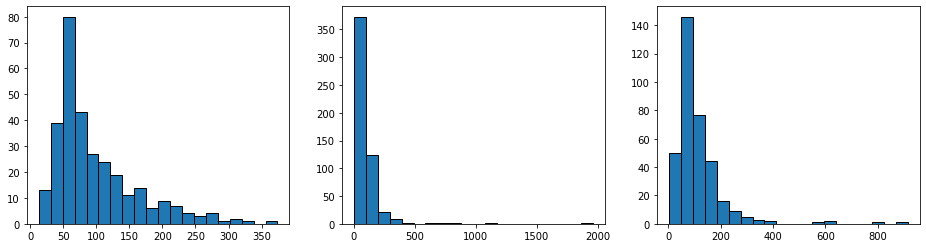

In [101]:
column = 'donatore_fosfatasi'

plt.figure(figsize=(16, 4))

if show_plot:
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.hist(data=df, x=column + str(i), bins=20, edgecolor='black')
        
for i in range(1, 4):
    print('Missing {}: {:.2f}'.format(column + str(i), get_freq_nan_tx(df, column + str(i))))

To overcome the large number of missing values we can calculate the mean over the three measurements:

In [102]:
index = df.columns.get_loc('donatore_fosfatasi3')+1
df.insert(index, 'donatore_fosfatasi_avg', False)

df['donatore_fosfatasi_avg'] = df.apply(lambda x: compute_mean(x, 'donatore_fosfatasi'), axis=1)

df.drop('donatore_fosfatasi1', axis=1, inplace=True)
df.drop('donatore_fosfatasi2', axis=1, inplace=True)
df.drop('donatore_fosfatasi3', axis=1, inplace=True)

Missing donatore_fosfatasi_avg: 0.19


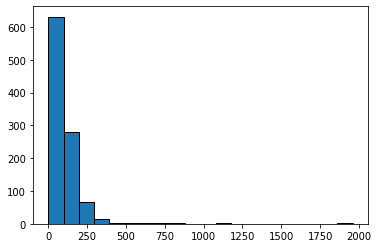

In [103]:
column = 'donatore_fosfatasi_avg'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_gammaGT`

Missing donatore_gammaGT1: 0.45
Missing donatore_gammaGT2: 0.37
Missing donatore_gammaGT3: 0.45


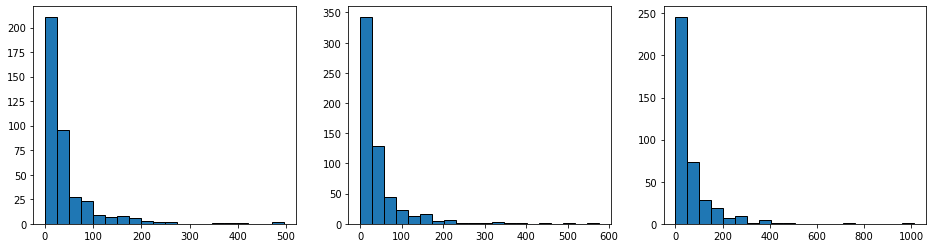

In [104]:
column = 'donatore_gammaGT'

plt.figure(figsize=(16, 4))

if show_plot:
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.hist(data=df, x=column + str(i), bins=20, edgecolor='black')
        
for i in range(1, 4):
    print('Missing {}: {:.2f}'.format(column + str(i), get_freq_nan_tx(df, column + str(i))))

To overcome the large number of missing values we can calculate the mean over the three measurements:

In [105]:
index = df.columns.get_loc('donatore_gammaGT3')+1
df.insert(index, 'donatore_gammaGT_avg', False)

df['donatore_gammaGT_avg'] = df.apply(lambda x: compute_mean(x, 'donatore_gammaGT'), axis=1)

df.drop('donatore_gammaGT1', axis=1, inplace=True)
df.drop('donatore_gammaGT2', axis=1, inplace=True)
df.drop('donatore_gammaGT3', axis=1, inplace=True)

Missing donatore_gammaGT_avg: 0.14


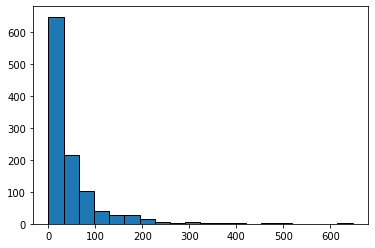

In [106]:
column = 'donatore_gammaGT_avg'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_arresto_cardiaco`

Missing donatore_arresto_cardiaco: 0.11


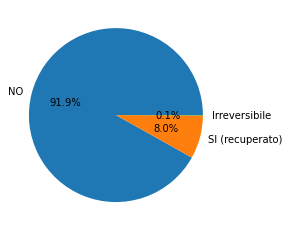

In [107]:
column = 'donatore_arresto_cardiaco'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_hcv`

Missing donatore_hcv: 0.09


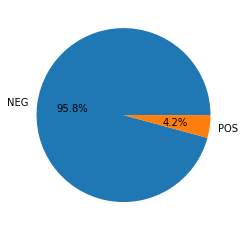

In [108]:
column = 'donatore_hcv'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_hcv_rna`

In [109]:
column = 'donatore_hcv_rna'
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

Missing donatore_hcv_rna: 0.25


Like before, Hepatitis C RNA can only be present along with Hepatitis C. So if `donatore_hcv` is not detected (value `NEG`) then `donatore_hcv_rna` should not be present.

In [110]:
for i in range(len(df)):
    if pd.isna(df.iloc[i]['donatore_hcv_rna']) and df.iloc[i]['donatore_hcv'] == 'NEG':
        df.loc[i, 'donatore_hcv_rna'] = 'NEG'

Missing donatore_hcv_rna: 0.09


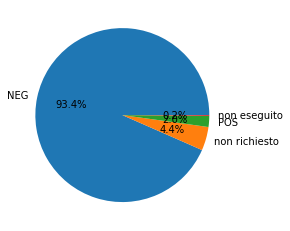

In [111]:
column = 'donatore_hcv_rna'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_HBsAg`

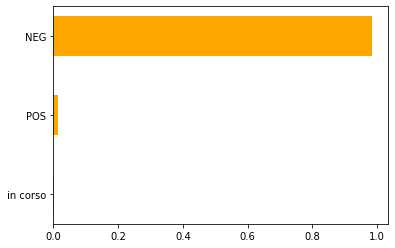

In [112]:
column = 'donatore_HBsAg'
plot_barh(df[column], show_plot)

In [113]:
df.loc[df['donatore_HBsAg'] == 'in corso', 'donatore_HBsAg'] = np.nan

Missing donatore_HBsAg: 0.09


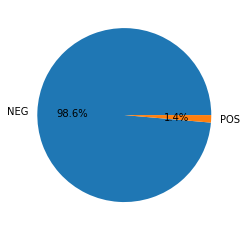

In [114]:
column = 'donatore_HBsAg'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_HBsAb`

Missing donatore_HBsAb: 0.24


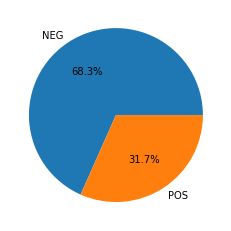

In [115]:
column = 'donatore_HBsAb'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_HBeAb`

Missing donatore_HBeAb: 0.56


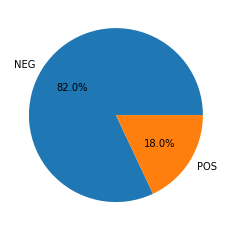

In [116]:
column = 'donatore_HBeAb'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_antiCoreTot`

Missing donatore_antiCoreTot: 0.09


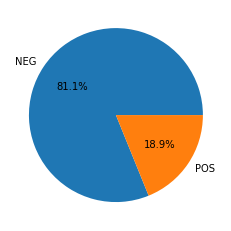

In [117]:
column = 'donatore_antiCoreTot'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_hbv_dna`

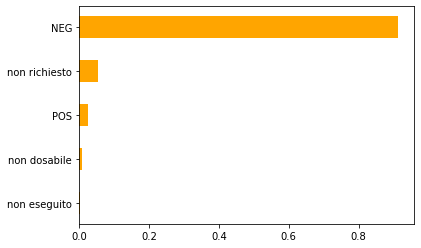

In [118]:
column = 'donatore_hbv_dna'
plot_barh(df[column], show_plot)

In [119]:
values_to_remove = ['non richiesto', 'non dosabile', 'non eseguito']
df.loc[df['donatore_hbv_dna'].isin(values_to_remove) , 'donatore_hbv_dna'] = np.nan

Missing donatore_hbv_dna: 0.28


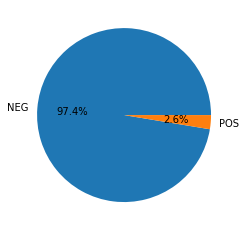

In [120]:
column = 'donatore_hbv_dna'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_hcv_rna`

In [121]:
values_to_remove = ['non richiesto', 'non dosabile', 'non eseguito']
df.loc[df['donatore_hcv_rna'].isin(values_to_remove) , 'donatore_hcv_rna'] = np.nan

Missing donatore_hcv_rna: 0.12


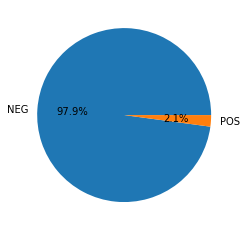

In [122]:
column = 'donatore_hcv_rna'
plot_pie(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_steatosiMacro`

Missing donatore_steatosiMacro: 0.29


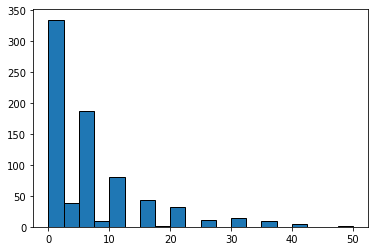

In [123]:
column = 'donatore_steatosiMacro'
plot_hist(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

- Feature: `donatore_livelloRischioPreLT`

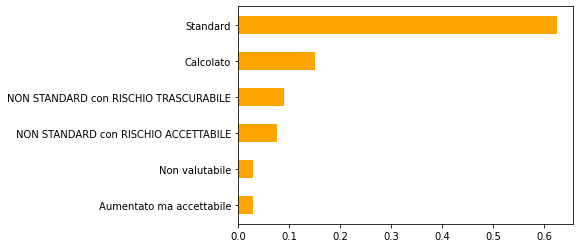

In [124]:
column = 'donatore_livelloRischioPreLT'
plot_barh(df[column], show_plot)

In [125]:
df.loc[df['donatore_livelloRischioPreLT'] == 'Non valutabile', 'donatore_livelloRischioPreLT'] = np.nan
df.loc[df['donatore_livelloRischioPreLT'].str.contains('NON STANDARD', na=False), 'donatore_livelloRischioPreLT'] = 'Non standard'

Missing donatore_livelloRischioPreLT: 0.13


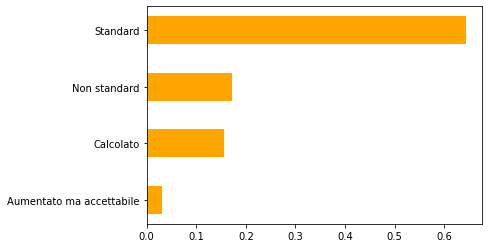

In [126]:
column = 'donatore_livelloRischioPreLT'
plot_barh(df[column], show_plot)
print('Missing {}: {:.2f}'.format(column, get_freq_nan_tx(df, column)))

### Removing columns with too many missing values

The columns with more than 30% `NaN` are removed because they contain too many missing values:

In [127]:
df = df.drop(columns=['MELD_in_ingresso', 'MELD_in_uscita', 'MELD_na', 'MELD_HCC', 'AFP', 'donatore_HBeAb'])

<h2><span style="color:#191996">5. Creation of X and y</span></h2>

For **estimating the 5-year survival**, only `causa_uscita = TX nel centro di iscrizione` is considered:

In [128]:
df_tx = df[df['causa_uscita'] == 'TX nel centro di iscrizione'].drop(columns=['causa_uscita'])

print('Number of patients: {}'.format(len(df_tx)))

Number of patients: 1423


### Creating X

In [129]:
X = df_tx.copy(deep=True)

In [130]:
# drop useless dates
X = X.drop(columns=['lista_ingresso_data', 'lista_uscita_data'])

# very limited number of patients (5) have ISO2_super_urgenza: dropping the column
X = X.drop(columns=['ISO2_super_urgenza'])

# very limited number of patients (5) have rigetto: dropping the column
X = X.drop(columns=['rigetto'])

# very limited number of patients (11) have tipo_donazione != Cadavere: dropping the column
X = X.drop(columns=['tipo_donazione'])

# a single patient has donatore_arresto_cardiaco == Irreversibile: dropping it
idx = X.loc[X['donatore_arresto_cardiaco'] == 'Irreversibile'].index
X = X.drop(idx, axis=0)

In [131]:
print("Large number of diagnosis ({}), the 4 most frequent (Epatocarcinoma associato a cirrosi, Cirrosi postnecrotica da HCV, Cirrosi di Laennec (post-alcolica), Ritrapianto/rigetto di trapianto epatico) are kept, the others are considered together with value Altro".format(len(X['diagnosi'].value_counts().index)))

Large number of diagnosis (46), the 4 most frequent (Epatocarcinoma associato a cirrosi, Cirrosi postnecrotica da HCV, Cirrosi di Laennec (post-alcolica), Ritrapianto/rigetto di trapianto epatico) are kept, the others are considered together with value Altro


In [132]:
# nan are kept and not encoded as 'Altro'
diagnosis_to_keep = [np.nan, 'Epatocarcinoma associato a cirrosi', 'Cirrosi postnecrotica da HCV', 'Cirrosi di Laennec (post-alcolica)', 'Ritrapianto/rigetto di trapianto epatico']

X['diagnosi'] = X['diagnosi'].apply(lambda d: 'Altro' if d not in diagnosis_to_keep else d)

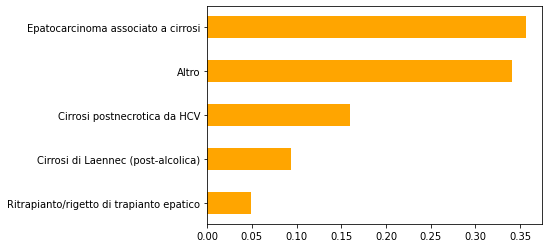

In [133]:
plot_barh(X['diagnosi'], True)

In [134]:
print("Large number of donatore_caus_decesso ({}), the 4 most frequent (Emorragia cerebrale, Trauma cranico, Encefalopatia post-anossica, Ictus ischemico) are kept, the others are considered together with value Altro".format(len(X['donatore_caus_decesso'].value_counts().index)))

Large number of donatore_caus_decesso (10), the 4 most frequent (Emorragia cerebrale, Trauma cranico, Encefalopatia post-anossica, Ictus ischemico) are kept, the others are considered together with value Altro


In [135]:
# nan are kept and not encoded as 'Altro'
caus_decesso_to_keep = [np.nan, 'Emorragia cerebrale', 'Trauma cranico', 'Encefalopatia post-anossica', 'Ictus ischemico']

X['donatore_caus_decesso'] = X['donatore_caus_decesso'].apply(lambda d: 'Altro' if d not in caus_decesso_to_keep else d)

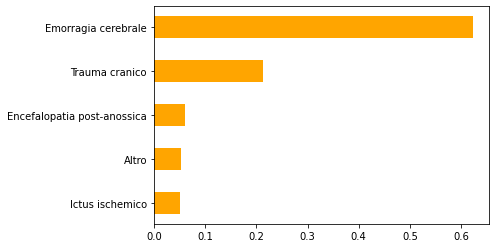

In [136]:
plot_barh(X['donatore_caus_decesso'], True)

### Encoding X
One-hot encoding for `diagnosi`:

In [137]:
def one_hot_nan (row, column_names):
    if row[column_names].sum() == 0:
        # all the values are 0 -> one hot encoding of nan
        return [np.nan]*len(column_names)
    else:
        return row[column_names]

In [138]:
dummy = pd.get_dummies(X['diagnosi'], dummy_na=True)

X['diagnosi_epatocarcinoma'] = dummy['Epatocarcinoma associato a cirrosi']
X['diagnosi_cirrosi_hcv'] = dummy['Cirrosi postnecrotica da HCV']
X['diagnosi_cirrosi_laennec'] = dummy['Cirrosi di Laennec (post-alcolica)']
X['diagnosi_ritrapianto_rigetto'] = dummy['Ritrapianto/rigetto di trapianto epatico']
X['diagnosi_altro'] = dummy['Altro']

columns = ['diagnosi_epatocarcinoma', 'diagnosi_cirrosi_hcv', 'diagnosi_cirrosi_laennec', 'diagnosi_ritrapianto_rigetto', 'diagnosi_altro']
        
X[columns] = X[columns].apply(lambda row: one_hot_nan(row, columns), axis=1)

# column diagnosi can be dropped
X = X.drop(columns=['diagnosi'])

One-hot encoding for `donatore_caus_decesso`:

In [139]:
dummy = pd.get_dummies(X['donatore_caus_decesso'])

X['donatore_caus_decesso_emorragia'] = dummy['Emorragia cerebrale']
X['donatore_caus_decesso_trauma'] = dummy['Trauma cranico']
X['donatore_caus_decesso_encefalopatia'] = dummy['Encefalopatia post-anossica']
X['donatore_caus_decesso_ictus'] = dummy['Ictus ischemico']
X['donatore_caus_decesso_altro'] = dummy['Altro']

columns = ['donatore_caus_decesso_emorragia', 'donatore_caus_decesso_trauma', 'donatore_caus_decesso_encefalopatia', 'donatore_caus_decesso_ictus', 'donatore_caus_decesso_altro']

X[columns] = X[columns].apply(lambda row: one_hot_nan(row, columns), axis=1)

# column donatore_caus_decesso can be dropped
X = X.drop(columns=['donatore_caus_decesso'])

Decision Trees work well with categorical variables, but to perform missing values imputation we need to encode the categorical variables.

`M`/`F` needs to be encoded with `0`/`1`, same for `NO`/`SI` and `NEG`/`POS`:

In [140]:
def encode_01 (value):
    if value == 'M' or value == 'NO' or value == 'NEG':
        return 0
    elif value == 'F' or value == 'SI' or value == 'POS':
        return 1
    elif pd.isna(value):
        return np.nan
    else:
        raise ValueError("{} can not be encoded with the specified rules!".format(value))

columns_to_encode = ['pers_sesso', 'ric_HBsAg', 'ric_DELTA', 'ric_HCV', 'ric_HCV_RNA', 'ric_HIV', 'chirurgia_addom', 'TIPS', 'ric_diabete', 'HCC', 'dialisi_ultimi_15gg', 'donatore_sesso', 'donatore_cardiopatia', 'donatore_ipertensione', 'donatore_diabete', 'donatore_diabete_insulinodipendente', 'donatore_dislipidemie', 'donatore_hcv', 'donatore_HBsAg', 'donatore_HBsAb', 'donatore_antiCoreTot', 'donatore_hbv_dna', 'donatore_hcv_rna']
for c in columns_to_encode:
    X[c] = X[c].apply(encode_01)

In [141]:
# encoding for ric_ripresa_funzionale (Ripresa immediata / PGNF) and donatore_arresto_cardiaco (NO / SI (recuperato))
X['ric_ripresa_funzionale'] = X['ric_ripresa_funzionale'].apply(lambda v: 0 if v == 'Ripresa immediata' else 1)
X['donatore_arresto_cardiaco'] = X['donatore_arresto_cardiaco'].apply(lambda v: 0 if v == 'NO' else 1)

Ordinal encoding for `trombosi_portale`, `UNOS`, `CHILD`:

In [142]:
def encode_ordinal (value, dictionary):
    if not pd.isna(value):
        return dictionary[value]
    else:
        return np.nan

In [143]:
d = {'NO': 0, 'PARZIALE': 1, 'SI': 2}
X['trombosi_portale'] = X['trombosi_portale'].apply(lambda v: encode_ordinal(v, d))

d = {'3': 1, '2B': 2, '2A': 3, '1': 4}
X['UNOS'] = X['UNOS'].apply(lambda v: encode_ordinal(v, d))

d = {'A5': 1, 'A6': 2, 'B7': 3, 'B8': 4, 'B9': 5, 'C10': 6, 'C11': 7, 'C12': 8, 'C13': 9, 'C14': 10, 'C15': 11}
X['CHILD'] = X['CHILD'].apply(lambda v: encode_ordinal(v, d))

Ordinal encoding for `ric_ospedalizzazione_al_tx`, `organo_trapiantato`, `donatore_livelloRischioPreLT`:

In [144]:
d = {'Non Ospedalizzato': 0, 'Ospedalizzato In Reparto': 1, 'Ospedalizzato In Terapia Intensiva / Rianimazione': 2}
X['ric_ospedalizzazione_al_tx'] = X['ric_ospedalizzazione_al_tx'].apply(lambda v: encode_ordinal(v, d))

d = {'Fegato intero': 0, 'Fegato split Sx': 1, 'Fegato split Dx': 1} # split sx and split dx merged together
X['organo_trapiantato'] = X['organo_trapiantato'].apply(lambda v: encode_ordinal(v, d))

d = {'Standard': 1, 'Non standard': 2, 'Calcolato': 3, 'Aumentato ma accettabile': 4}
X['donatore_livelloRischioPreLT'] = X['donatore_livelloRischioPreLT'].apply(lambda v: encode_ordinal(v, d))

### Creating label y

In [145]:
def obtain_label (row, years):
    # based on the transplant date and on the update information known
    # 0 -> patient died before <years>
    # 1 -> patient survived at least <years>
    
    tx_date = row['data_trapianto']    
    death_date = None
    
    if not pd.isna(row['data_decesso']):
        death_date = row['data_decesso']        
    elif pd.isna(row[['data_ultimo_agg_followup', 'ultimo_stato_tx']]).tolist() == [False, False] \
            and row['ultimo_stato_tx'] == 'Paziente deceduto':
        death_date = row['data_ultimo_agg_followup']
    
    if death_date != None:
        delta_days = (death_date - tx_date).days        
        if delta_days < 365*years:
            return 0
    
    # seems alive
    return 1

In [146]:
years = 5

y = X.apply(lambda row: obtain_label(row, years), axis=1)

# we can now drop 'data_decesso', 'data_ultimo_agg_followup', 'ultimo_stato_tx', 'data_trapianto'
X = X.drop(columns=['data_decesso', 'data_ultimo_agg_followup', 'ultimo_stato_tx', 'data_trapianto'])

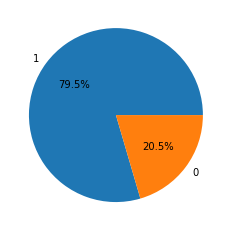

In [147]:
plot_pie(y, True)

Creating train and test split:

In [148]:
X_train_nan, X_test_nan, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

print("X train length: {}\nX test length: {}".format(len(X_train_nan), len(X_test_nan)))

X train length: 1137
X test length: 285


### Iterative Imputation
It seems that the missing data are Missing Completely At Random (MCAR): 
\begin{equation}
P(m | X_o, X_m) = P(m)
\end{equation}

But a more conservative assumption is Missing At Random (MAR): 
\begin{equation}
P(m | X_o, X_m) = P(m | X_o)
\end{equation}

With MAR data we can use the `IterativeImputer`:

> A strategy for imputing missing values by modeling each feature as a function of other features in a round-robin fashion.




Given:
- an estimator $E$ (default Bayesian Ridge);
- known data $X^k$ and missing data $X^m$;
- a tolerance $tol$;
- a maximum number of iterations $max\_iter$

The missing values are estimated in a _round-robin_ fashion:

1. initially replace all the missing values with values derived solely from non-missing values of the considered feature $c$:
\begin{equation}
for\;i=1..u\;\;X^m_{c, i} = \underset{j=1..n}{\operatorname{avg(X^k_{c, j})}}
\end{equation}
2. starting from a feature $c$, train $E$ on the other features:
\begin{equation}
E.fit(X^k_{f \ne c}, X^k_{f=c})
\end{equation}
3. use the fitted estimator to predict the missing values of feature $c$:
\begin{equation}
X^m_{f=c} = E.predict(X^m_{f \ne c})
\end{equation}
4. repeat step 2 and 3 for every feature $c$ containing missing values

Cycle $max\_iter$ times from step 2 to 4. Stop earlier if
\begin{equation}
\frac{max{|X^{m,t} - X^{m,{t-1}}|}}{max{|X^k|}} < tol
\end{equation}
where $X^{m,t}$ is $X^m$ at iteration $t$


Missing value imputation using `IterativeImputer`:

In [149]:
imputer = IterativeImputer(max_iter=20,
                           min_value=get_min_value(),
                           max_value=get_max_value(),
                           random_state=seed)
imputer.fit(X_train_nan);

In [150]:
X_train_imputed_array = imputer.transform(X_train_nan)
X_test_imputed_array = imputer.transform(X_test_nan)

X_train = pd.DataFrame(X_train_imputed_array, index=X_train_nan.index, columns=X_train_nan.columns)
X_test = pd.DataFrame(X_test_imputed_array, index=X_test_nan.index, columns=X_test_nan.columns)

After the imputation, intermediate values are not rounded because this additional information can be useful for the classifier.

In [151]:
column = 'MELD_base'
X_train[pd.isna(X_train_nan[column])][column].head(10)

1329    36.438298
1317    33.285712
26      21.890872
1311    36.829147
1307    30.502734
1312    31.285613
1320    32.123120
1289    22.910498
1302    32.892821
1297    22.785558
Name: MELD_base, dtype: float64

<h2><span style="color:#191996">6. Training the classifiers</span></h2>

In this application, evaluating a classifier using its accuracy is not totally correct: different errors have different costs. Instead, we are interested in minimizing a loss (or cost) that tell us how well our model is performing. The cost matrix is defined as:

In [152]:
cost_matrix = {'TP': 0, 'TN': 0, 'FP': 8, 'FN': 1}

It is fair to assume that the cost associated with a `False Positive` is higher than the cost associated with a `False Negative`. Still, these numbers should come from an expert. Those proposed are only a guess for the purpose of the study.

A custom score function (that depends on the cost matrix above) is created:

In [153]:
custom_score = make_scorer(get_cost, greater_is_better=False, cost_matrix=cost_matrix)

### Dummy Classifier
Classifier that makes predictions using simple rules, like:
- always predict `most frequent` class (default)
- random predictions according to the class distribution (`stratified`)
- predictions uniformly at random (`uniform`)

Useful as a simple **baseline**.

In [154]:
dummy = DummyClassifier(random_state=seed)
dummy.fit(X_train, y_train)
print('Dummy classifier cost (train): {}'.format(-custom_score(dummy, X_train, y_train)))
print('Dummy classifier cost (test): {}'.format(-custom_score(dummy, X_test, y_test)))

Dummy classifier cost (train): 1864
Dummy classifier cost (test): 464


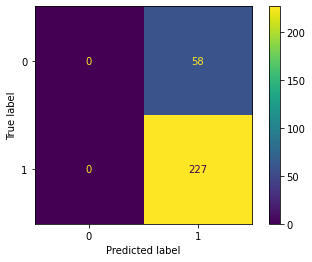

In [156]:
plot_confusion_matrix(dummy, X_test, y_test);

### Random Forest Classifier
- Ensemble of _n_ Decision Trees: $T_1$ ... $T_n$
- $T_i$ is trained on $D_i$
- $D_i$ is obtained by sampling with replacement from the original dataset $D$ (_boostrap aggregating_, `bootstrap = True` parameter)
- each tree cast a vote for the prediction

This technique reduces the variance without increasing the bias as long as the trees are uncorrelated.

If a particular subset of features is particularly predictive, the trees could remain correlated: Random Forest trees use a random subset of features for each split (`max_features` parameter).

#### Cross-validation on Random Forest

In [217]:
param_grid = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 51)),
    'min_samples_split': list(range(2, 6)),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}]

classifier = RandomForestClassifier(class_weight={1: 1, 0: 1}, random_state=seed)

grid_search = GridSearchCV(classifier, param_grid, scoring=custom_score, cv=5, n_jobs=4)

grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

-302.0
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'min_samples_split': 5}


In [157]:
cls_forest = RandomForestClassifier(criterion = 'entropy',
                                    max_depth = 12,
                                    bootstrap = False,     # no boostrap aggregating
                                    max_features = None,   # all the features are used at each split
                                    min_samples_split = 5, # min number of samples to create a split
                                    random_state = seed)

cls_forest.fit(X_train, y_train)

print('Random Forest cost (train): {}'.format(-custom_score(cls_forest, X_train, y_train)))
print('Random Forest cost (test): {}'.format(-custom_score(cls_forest, X_test, y_test)))

Random Forest cost (train): 557
Random Forest cost (test): 412


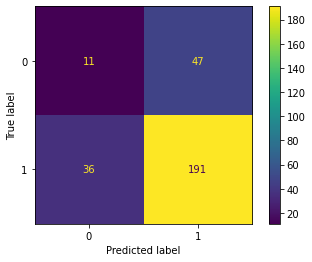

In [158]:
plot_confusion_matrix(cls_forest, X_test, y_test);

### Extra Trees Classifier

Similar to the Random Forest classifier, but with some differences [5]:
- generally `bootstrap = False`, so each tree is trained on the whole dataset
- at each node, propose a random splits for each feature: the best split is used

#### Cross-validation on Extra Trees

In [162]:
param_grid = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 51)),
    'min_samples_split': list(range(2, 6)),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}]

classifier = ExtraTreesClassifier(class_weight={1: 1, 0: 1}, random_state=seed)

grid_search = GridSearchCV(classifier, param_grid, scoring=custom_score, cv=5, n_jobs=4)

grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

-325.2
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 22, 'max_features': None, 'min_samples_split': 2}


In [160]:
cls_extra = ExtraTreesClassifier(criterion = 'gini',
                                 max_depth = 22,
                                 bootstrap = False,     # no boostrap aggregating
                                 max_features = None,   # all the features are used at each split
                                 min_samples_split = 2, # min number of samples to create a split
                                 random_state = seed)

cls_extra.fit(X_train, y_train)

print('Extra Trees cost (train): {}'.format(-custom_score(cls_extra, X_train, y_train)))
print('Extra Trees cost (test): {}'.format(-custom_score(cls_extra, X_test, y_test)))

Extra Trees cost (train): 0
Extra Trees cost (test): 389


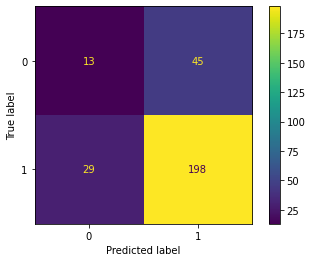

In [161]:
plot_confusion_matrix(cls_extra, X_test, y_test);

### Comparison

It seems that the increased randomization used by the Extra Trees is beneficial.

Apart from depth, there are no other very important differences between the Random Fores and the Extra Trees used above as both are trained without bootstrap aggregating and on the whole set of features.

| Classifier    | Cost (test set)|
|---------------|----------------|
| Dummy         | 464            |
| Random Forest | 412            |
| Extra Trees   | 389            |

### Feature importance with boruta

**Boruta** is a powerful feature selection algorithm:
- based on Random Forest
- works well without tuning

The algorithm:

1. For each feature $f_j$ a _shadown feature_ $s_j$ is created making a copy of $f_j$'s values and shuffling them (to remove their correlations with y). This way the number of features doubles;
2. Train a Random Forest classifier on the extended dataset. Only the features that are more important than the most important shadow feature score a point (hit);
3. Repeat step 1-2 `max_iter` times accumulating hits;
4. At the end, depending on the accumulated hits, each feature $f_j$ has support (or weak support) or not.

In [184]:
forest = RandomForestClassifier(max_depth=5, n_jobs=4, random_state=seed)
boruta = BorutaPy(estimator=forest, n_estimators='auto', max_iter=100, random_state=seed)

boruta.fit(np.array(X_train), y_train);

In [172]:
X_train.columns[boruta.support_].to_list()

['BMI',
 'MELD_base',
 'dialisi_ultimi_15gg',
 'donatore_bilirubinaTot_avg',
 'donatore_gammaGT_avg']

In [173]:
X_train.columns[boruta.support_weak_].to_list()

['ric_HCV_RNA', 'CHILD']

### Bibliography

[1] https://ui.adsabs.harvard.edu/abs/1987Natur.329..343M/abstract

[2] https://www.cdc.gov/hepatitis/hcv/pdfs/hcv_graph.pdf

[3] https://www.pennmedicine.org/updates/blogs/transplant-update/2020/may/understanding-the-meld-score

[4] https://www.gastrojournal.org/article/S0016-5085(03)50022-1/fulltext

[5] https://orbi.uliege.be/bitstream/2268/9357/1/geurts-mlj-advance.pdf